In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
import keras_preprocessing


from sklearn.impute import KNNImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTENC

print(tf.config.list_physical_devices("GPU"))


[]


2022-09-08 01:12:22.329011: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-09-08 01:12:22.329160: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: haoming-t480s
2022-09-08 01:12:22.329193: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: haoming-t480s
2022-09-08 01:12:22.329462: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.65.1
2022-09-08 01:12:22.329582: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.65.1
2022-09-08 01:12:22.329622: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.65.1


In [11]:
def read_and_shuffle_data():
    full_data = pd.read_csv(Path().resolve().joinpath("dataset/train_2v.csv"))

    full_data[
        ["hypertension", "heart_disease", "ever_married", "smoking_status"]
    ] = full_data[
        [
            "hypertension",
            "heart_disease",
            "ever_married",
            "smoking_status",
        ]
    ].replace(
        {1: "Yes", 0: "No", "Unknown": np.nan}
    )

    shuffled = full_data.sample(frac=1, random_state=0).drop(columns="id")

    return shuffled


def encode_int(
    data: pd.DataFrame, enc: OrdinalEncoder, categorical_features: list[str]
):
    enc.fit(data[categorical_features])

    data.loc[:, data[categorical_features].columns] = enc.fit_transform(
        data[categorical_features]
    )

    return data


def decode_int(
    data: pd.DataFrame, enc: OrdinalEncoder, categorical_features: list[str]
):
    data.loc[:, data[categorical_features].columns] = enc.inverse_transform(
        data[categorical_features]
    )

    return data


def impute_missing(data: DataFrame, header, categorical_features, numerical_features):
    imp_cat = IterativeImputer(
        estimator=RandomForestClassifier(),
        initial_strategy="most_frequent",
        max_iter=10,
        random_state=0,
    )

    imp_num = IterativeImputer(
        estimator=RandomForestRegressor(),
        initial_strategy="mean",
        max_iter=10,
        random_state=0,
    )

    data[categorical_features] = imp_cat.fit_transform(data[categorical_features])
    data[numerical_features] = imp_num.fit_transform(data[numerical_features])

    return data


def resample(data: pd.DataFrame, cat_features: list[str]):
    """oversample positive cases with SMOTE and undersample negative with EEN"""
    X = data.drop(columns=["stroke"], axis=1)
    Y = data["stroke"]

    cat_features_indices = [data.columns.get_loc(name) for name in cat_features]

    smote_nc = SMOTENC(categorical_features=cat_features_indices, random_state=0)
    smote_een = SMOTEENN(random_state=0, sampling_strategy="auto")

    # x_resampled, y_resampled = smote_een.fit_resample(X, Y)
    x_resampled, y_resampled = smote_een.fit_resample(X, Y)
    x_resampled["stroke"] = y_resampled

    # return DataFrame(enc.inverse_transform(x_resampled), columns=data.columns)
    return DataFrame(x_resampled, columns=data.columns)


def generate_train_valid_test(
    shuffled_data_df: DataFrame,
    header: list,
    categorical_features: list,
    numerical_features: list,
):
    enc = OrdinalEncoder()

    data_df = encode_int(
        data=shuffled_data_df, enc=enc, categorical_features=categorical_features
    ).copy()

    data_df = impute_missing(
        data_df,
        header=header,
        categorical_features=categorical_features,
        numerical_features=numerical_features,
    )

    test_set = data_df[round(len(data_df) * 0.85) :]
    train_validation_data = data_df[: round(len(data_df) * 0.85)].sample(
        frac=1, random_state=0
    )

    train_set = train_validation_data[: round(len(data_df) * 0.70)]
    validation_set = train_validation_data[round(len(data_df) * 0.70) :]

    train_set = resample(train_set, cat_features=categorical_features)

    # decode the categorical features from ints
    train_df, validation_df, test_df, data_df = [
        decode_int(data=df, enc=enc, categorical_features=categorical_features)
        for df in [train_set, validation_set, test_set, data_df]
    ]

    return train_set, validation_set, test_set, data_df


def prepare_data_tvt(header, categorical_features, numerical_features):
    full_data_shuffled = read_and_shuffle_data()

    train_df, validation_df, test_df, full_data_df = generate_train_valid_test(
        full_data_shuffled, header, categorical_features, numerical_features
    )

    test_df.to_csv(
        Path().resolve().joinpath("dataset/test_data.csv"), index=False, header=False
    )

    validation_df.to_csv(
        Path().resolve().joinpath("dataset/validation_data.csv"),
        index=False,
        header=False,
    )

    train_df.to_csv(
        Path().resolve().joinpath("dataset/train_data.csv"), index=False, header=False
    )

    full_data_df.to_csv(
        Path().resolve().joinpath("dataset/full_data_clean.csv"), index=False
    )

    return test_df, train_df, validation_df


In [12]:
# prepare data
CSV_HEADER = [
    "gender",
    "age",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "residence_type",
    "avg_glucose_level",
    "bmi",
    "smoking_status",
    "stroke",
]

NUMERIC_FEATURE_NAMES = [
    "age",
    "avg_glucose_level",
    "bmi",
]  # list of numeric feature names

CATEGORICAL_FEATURE_NAMES = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "residence_type",
    "smoking_status",
]

train_data_path = Path().resolve().joinpath("dataset/train_data.csv")
validation_data_path = Path().resolve().joinpath("dataset/validation_data.csv")
test_data_path = Path().resolve().joinpath("dataset/test_data.csv")

train_data_file = str(train_data_path.absolute())
validation_data_file = str(validation_data_path.absolute())
test_data_file = str(test_data_path.absolute())

train_data = DataFrame()
validation_data = DataFrame()
test_data = DataFrame()

try:
    train_data = pd.read_csv(
        Path().resolve().joinpath("dataset/train_data.csv"), names=CSV_HEADER
    )

    validation_data = pd.read_csv(
        Path().resolve().joinpath("dataset/validation_data.csv"), names=CSV_HEADER
    )

    test_data = pd.read_csv(
        Path().resolve().joinpath("dataset/test_data.csv"), names=CSV_HEADER
    )

except:
    test_data, train_data, validation_data = prepare_data_tvt(
        header=CSV_HEADER,
        categorical_features=CATEGORICAL_FEATURE_NAMES,
        numerical_features=NUMERIC_FEATURE_NAMES,
    )

test_data, train_data, validation_data = prepare_data_tvt(
    header=CSV_HEADER,
    categorical_features=CATEGORICAL_FEATURE_NAMES,
    numerical_features=NUMERIC_FEATURE_NAMES,
)

print(
    f"Using {len(train_data)} samples for training, {len(validation_data)} for validation, and {len(test_data)} for test"
)

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "gender": sorted(list(train_data["gender"].unique())),
    "hypertension": sorted(list(train_data["hypertension"].unique())),
    "heart_disease": sorted(list(train_data["heart_disease"].unique())),
    "ever_married": sorted(list(train_data["ever_married"].unique())),
    "work_type": sorted(list(train_data["work_type"].unique())),
    "residence_type": sorted(list(train_data["residence_type"].unique())),
    "smoking_status": sorted(list(train_data["smoking_status"].unique())),
}

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
TARGET_FEATURE_NAME = "stroke"
TARGET_LABELS = ["1", "0"]

MLP_MODEL_PATH = str(Path().resolve().joinpath("model/mlp_model"))
TABTRANSFORMER_MODEL_PATH = str(Path().resolve().joinpath("model/tabtransformer_model"))


/home/haoming/.local/lib/python3.10/site-packages/sklearn/impute/_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/home/haoming/.local/lib/python3.10/site-packages/sklearn/impute/_iterative.py:713: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
/tmp/ipykernel_37321/2284164599.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, data[categorical_features].columns] = enc.inverse_transform(
/tmp/ipykernel_37321/2284164599.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

Using 53875 samples for training, 6510 for validation, and 6510 for test


In [13]:
# model hyperparameters

LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.1
BATCH_SIZE = 32
NUM_EPOCHS = 100
EPOCHS_TO_WAIT_FOR_IMPROVE = 5

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks.
NUM_HEADS = 4  # Number of attention heads.
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features.
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.


In [14]:
# data proccessing pipeline

target_label_lookup = layers.StringLookup(
    vocabulary=TARGET_LABELS, mask_token=None, num_oov_indices=0
)


def prepare_example(features, target):
    # target_index = target_label_lookup(target)
    target_index = target
    return features, target_index


def get_dataset_from_csv(csv_file_path, batch_size=128, shuffle=False):
    """dataset from, csv"""
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    ).map(prepare_example, num_parallel_calls=tf.data.AUTOTUNE, deterministic=False)
    return dataset.cache()


/home/haoming/.local/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
2022-09-06 13:54:49.158687: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-06 13:54:51.227858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 61 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:09:00.0, compute capability: 6.1
2022-09-06 13:54:51.243575: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1468 

In [15]:
def create_model_inputs():
    """Create model inputs"""
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs


def encode_inputs(inputs, embedding_dims):
    """Encode features"""

    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:

            # Use the numerical features as-is.
            numerical_feature = tf.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    print(encoded_categorical_feature_list)

    return encoded_categorical_feature_list, numerical_feature_list


In [16]:
# training and evaluation


def run_experiment(
    model: keras.Model,
    train_data_file,
    test_data_file,
    model_output,
    num_epochs,
    EPOCHS_TO_WAIT_FOR_IMPROVE,
    learning_rate,
    batch_size,
):
    """Implement a training and evaluation procedure"""
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=WEIGHT_DECAY
    )

    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_csv(test_data_file, batch_size)

    metrics = (
        [
            keras.metrics.BinaryAccuracy(name="acc"),
            keras.metrics.AUC(name="auc"),
        ],
    )

    # early_stop_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=EPOCHS_TO_WAIT_FOR_IMPROVE)
    # checkpoint_callback = keras.callbacks.ModelCheckpoint(model_output, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    early_stop_callback = keras.callbacks.EarlyStopping(
        monitor="val_auc", patience=EPOCHS_TO_WAIT_FOR_IMPROVE
    )

    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        model_output,
        monitor="val_auc",
        verbose=1,
        save_best_only=True,
        mode="max",
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics,
    )

    print("Start training the model...")

    history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=validation_dataset,
        callbacks=[checkpoint_callback, early_stop_callback],
    )

    print("Model training finished")

    _, accuracy, auc = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}% AUC: {auc}")

    return history, model


In [17]:
# MLP block
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):
    """MLP block"""

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)


def create_baseline_model(
    embedding_dims, num_mlp_blocks, mlp_hidden_units_factors, dropout_rate
):
    """MLP model without transformer layers"""

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Concatenate all features.
    features = layers.concatenate(
        encoded_categorical_feature_list + numerical_feature_list
    )
    # Compute Feedforward layer units.
    feedforward_units = [features.shape[-1]]

    # Create several feedforwad layers with skip connections.
    for layer_idx in range(num_mlp_blocks):
        features = create_mlp(
            hidden_units=feedforward_units,
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{layer_idx}",
        )(features)

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.relu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [18]:
# tabtransformer block


def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = tf.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = tf.range(start=0, limit=num_columns, delta=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=1, activation="sigmoid", name="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


[<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_1')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_2')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_3')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_4')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_5')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_6')>]
INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/mlp_model/assets
Total model weights: 81265


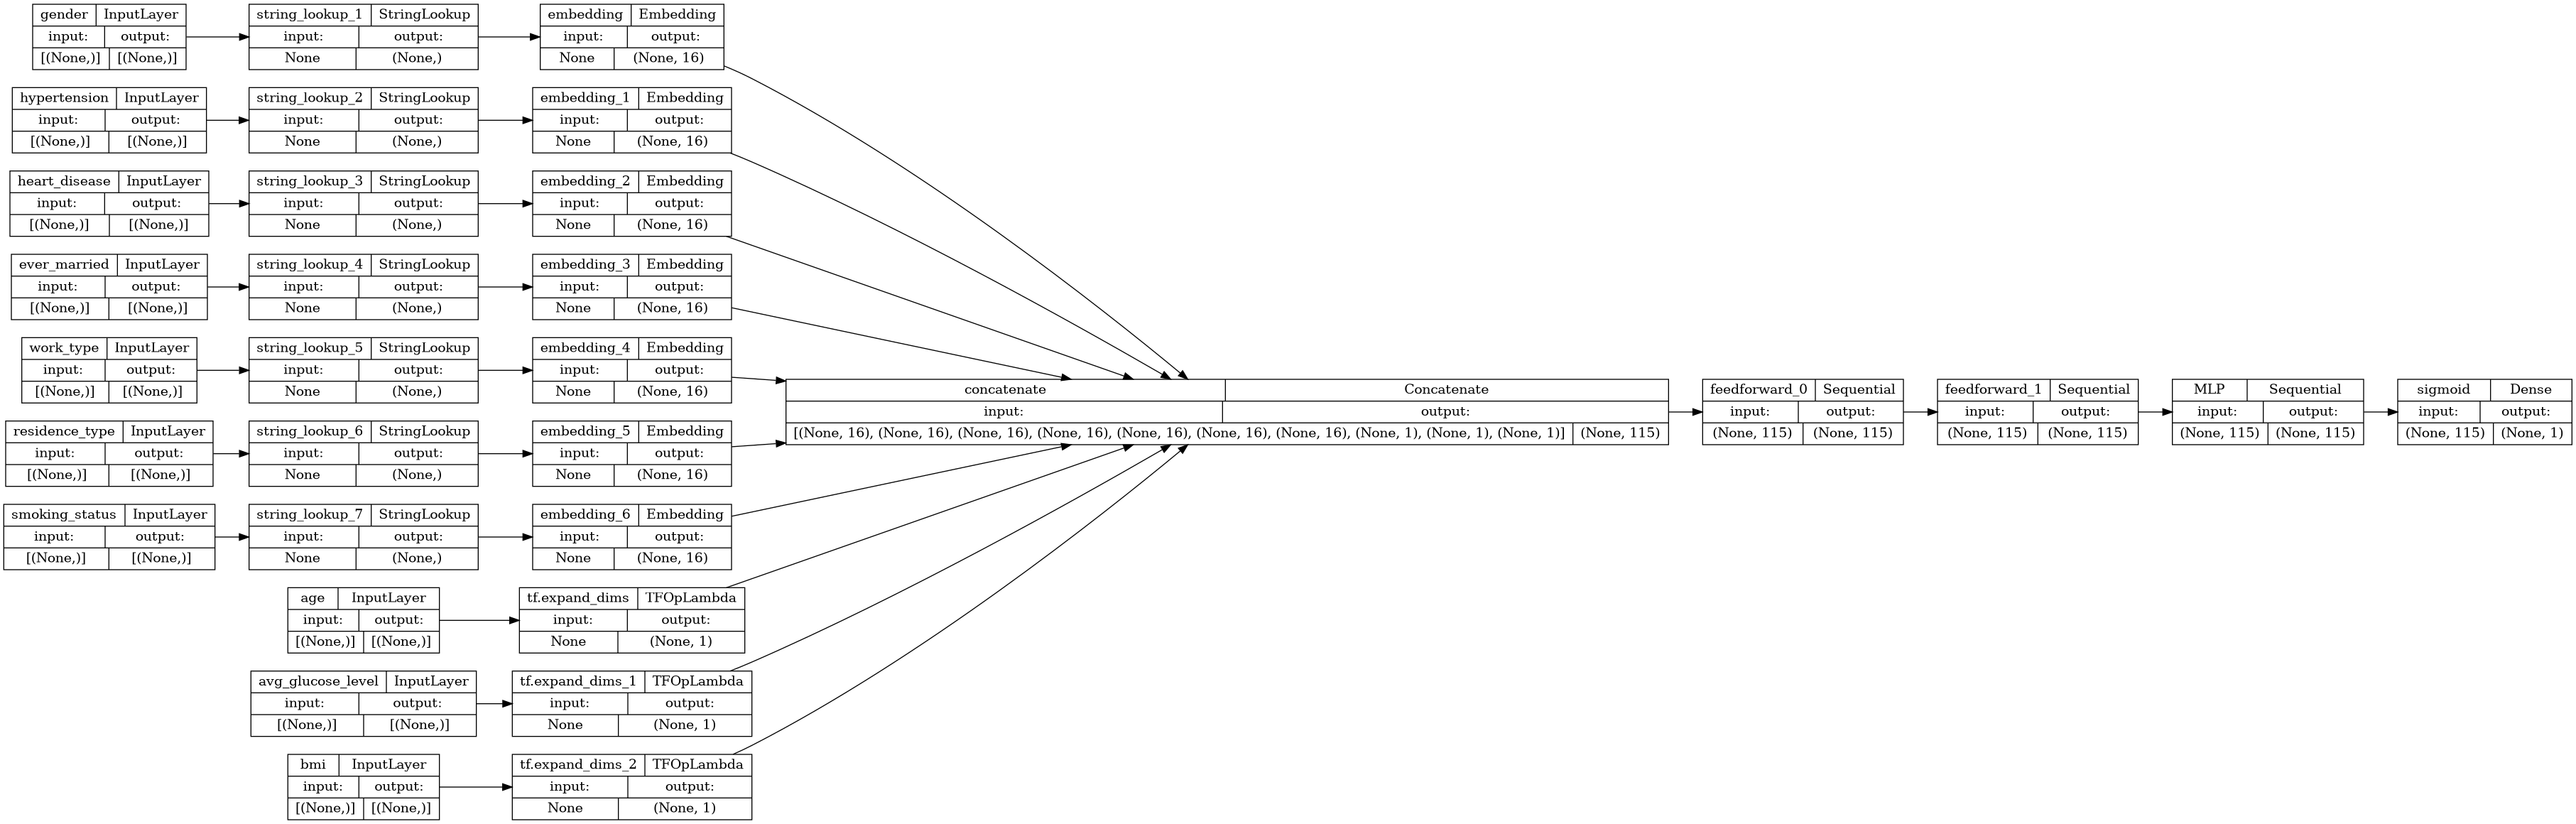

In [19]:
# define a baseline model without transformer layer

baseline_model = create_baseline_model(
    embedding_dims=EMBEDDING_DIMS,
    num_mlp_blocks=NUM_MLP_BLOCKS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

baseline_model.save(MLP_MODEL_PATH)

print("Total model weights:", baseline_model.count_params())
keras.utils.plot_model(baseline_model, show_shapes=True, rankdir="LR")


/home/haoming/.local/lib/python3.10/site-packages/numpy/core/numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


[<KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_7')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_8')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_9')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_10')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_11')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_12')>, <KerasTensor: shape=(None, 16) dtype=float32 (created by layer 'embedding_13')>]


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


INFO:tensorflow:Assets written to: /home/haoming/Projects/python/brain-stroke-prediction/model/tabtransformer_model/assets


Total model weights: 68147


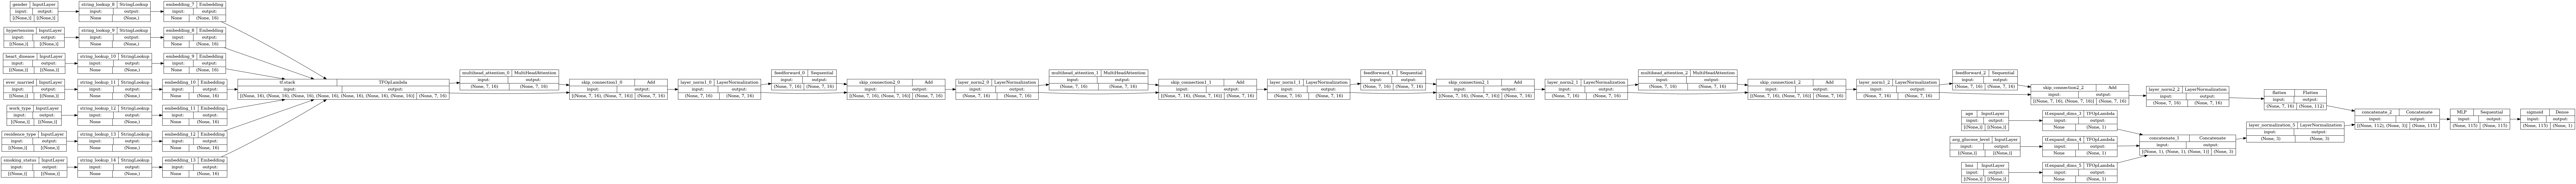

In [20]:
tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
    # use_column_embedding=True
)

tabtransformer_model.save(TABTRANSFORMER_MODEL_PATH)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")
